In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation,Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import pandas as pd
import cv2 as cv2
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import os

In [6]:
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [7]:
tf.test.is_built_with_cuda()

True

In [8]:
dir='./COVID-19_Radiography_Dataset/COVID-19_Radiography_Dataset'

filepaths=[]
labels=[]
classlist=os.listdir(dir)
for classes in classlist:
    classpath=os.path.join(dir,classes)
    if os.path.isdir(classpath):
        flist=os.listdir(classpath)
        for f in flist:
            fpath=os.path.join(classpath,f)
            filepaths.append(fpath)
            labels.append(classes)                   
Fseries= pd.Series(filepaths, name='filepaths')
Lseries=pd.Series(labels, name='labels')    
df=pd.concat([Fseries, Lseries], axis=1)
print (df.head())
print (df['labels'].value_counts())

                                           filepaths  labels
0  ./COVID-19_Radiography_Dataset/COVID-19_Radiog...  Normal
1  ./COVID-19_Radiography_Dataset/COVID-19_Radiog...  Normal
2  ./COVID-19_Radiography_Dataset/COVID-19_Radiog...  Normal
3  ./COVID-19_Radiography_Dataset/COVID-19_Radiog...  Normal
4  ./COVID-19_Radiography_Dataset/COVID-19_Radiog...  Normal
Normal             10192
Lung_Opacity        6012
COVID               3616
Viral Pneumonia     1345
Name: labels, dtype: int64


In [9]:
train_df, temp_df =train_test_split(df, train_size=0.9, shuffle=True, random_state=123)
test_df, valid_df =train_test_split(temp_df, train_size=0.5, shuffle=True, random_state=123)
print ('train_df length: ', len(train_df), '  test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))

train_df length:  19048   test_df length:  1058   valid_df length:  1059


In [10]:
height=224
width=224
channels=3
batch_size=32
img_shape=(height, width, channels)
img_size=(height, width)
length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]  
test_steps=int(length/test_batch_size)
def scalar(img):
    return img/255 
gen=ImageDataGenerator( 
    preprocessing_function=scalar,
    rotation_range=25,
    zoom_range=0.2,
    )
train_gen=gen.flow_from_dataframe( train_df,
                                  x_col='filepaths',
                                  y_col='labels',
                                  target_size=img_size,
                                  class_mode='categorical',
                                  color_mode='rgb',
                                  shuffle=True,
                                  batch_size=batch_size)
test_gen=gen.flow_from_dataframe( test_df,
                                 x_col='filepaths',
                                 y_col='labels',
                                 target_size=img_size,
                                 class_mode='categorical',
                                  color_mode='rgb',
                                  shuffle=False,
                                  batch_size=test_batch_size)
valid_gen=gen.flow_from_dataframe( valid_df,
                                  x_col='filepaths',
                                  y_col='labels',
                                  target_size=img_size,
                                  class_mode='categorical',
                                  color_mode='rgb',
                                  shuffle=False,
                                  batch_size=batch_size)
classes=list(train_gen.class_indices.keys())
print (classes)
class_count=len(classes)
#train_steps=int(len(train_gen.labels)/batch_size)

Found 19048 validated image filenames belonging to 4 classes.
Found 1058 validated image filenames belonging to 4 classes.
Found 1059 validated image filenames belonging to 4 classes.
['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']


In [11]:
def show_image_samples(gen ):
    test_dict=test_gen.class_indices
    classes=list(test_dict.keys())    
    images,labels=next(gen)
    plt.figure(figsize=(20, 20))
    length=len(labels)
    if length<25:   
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image=(images[i]+1 )/2 # scale images between 0 and 1 becaue pre-processor set them between -1 and +1
        plt.imshow(image,cmap='bone')
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='blue', fontsize=16)
        plt.axis('off')
    plt.show()


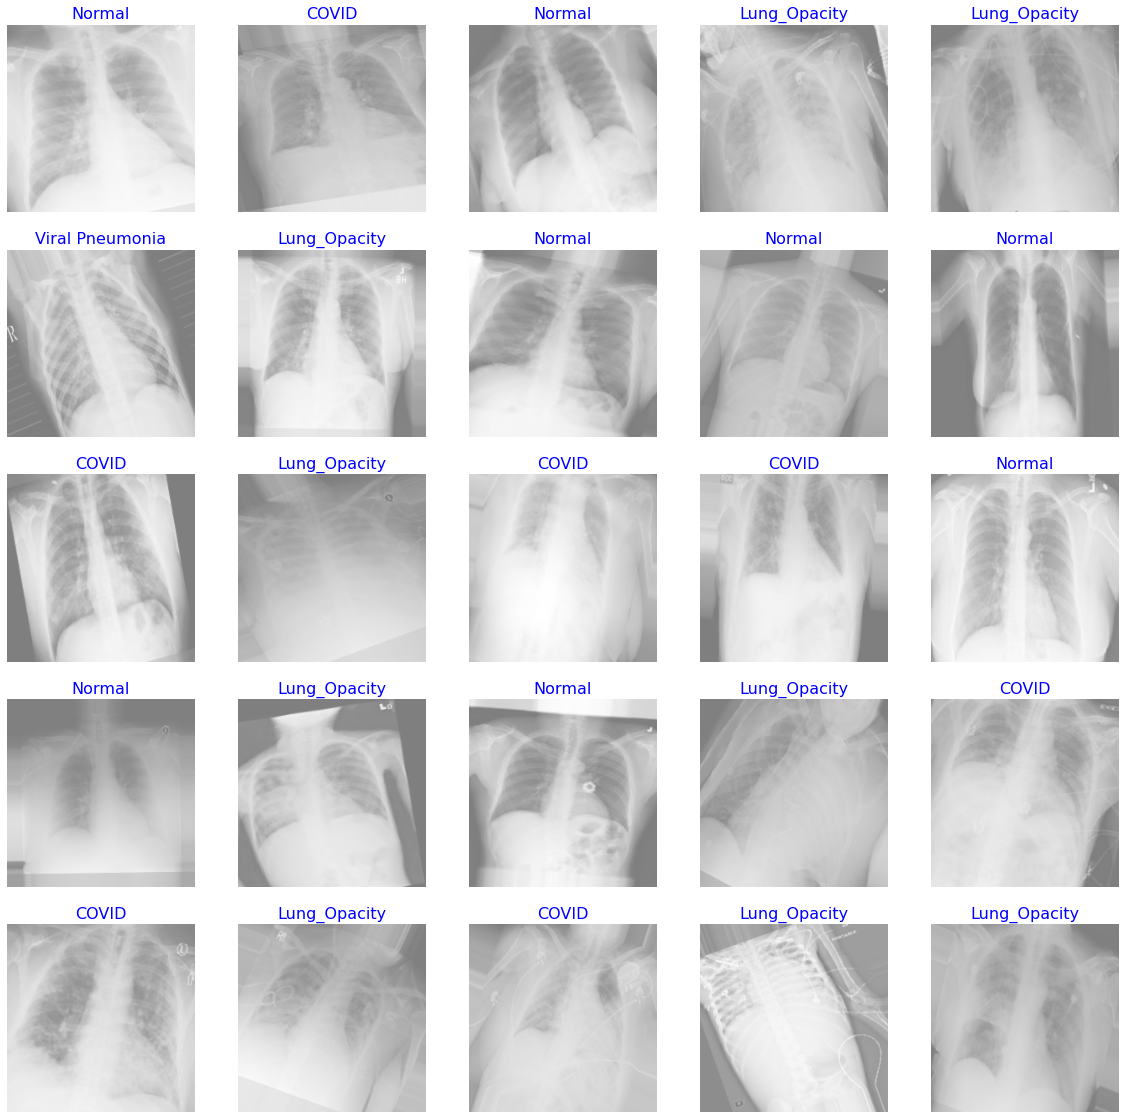

In [12]:
show_image_samples(train_gen)

In [13]:
model=tf.keras.applications.EfficientNetB0(
    include_top=True,
    weights=None,
    input_shape=(224,224,3)
    )

In [14]:
model.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 224, 224, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 225, 225, 3)  0           ['normalization[0][0

In [15]:
model_input=model.layers[0].input
model_output=model.layers[-3].output

In [16]:
model_output=tf.keras.layers.Dense(128)(model_output)
model_output=tf.keras.layers.Activation('relu')(model_output)
model_output=tf.keras.layers.Dropout(0.2)(model_output)
model_output=tf.keras.layers.Dense(64)(model_output)
model_output=tf.keras.layers.Activation('relu')(model_output)
model_output=tf.keras.layers.Dense(4,activation='softmax')(model_output)

In [17]:
final_model=tf.keras.Model(inputs=model_input,outputs=model_output)

In [18]:
final_model.compile(loss='categorical_crossentropy',optimizer=Adam(0.001),metrics=['Accuracy'])

In [19]:
history=final_model.fit(train_gen,epochs=15,validation_data=valid_gen,verbose=2)

Epoch 1/15
596/596 - 377s - loss: 0.8545 - Accuracy: 0.6620 - val_loss: 1.6327 - val_Accuracy: 0.3399 - 377s/epoch - 632ms/step
Epoch 2/15
596/596 - 333s - loss: 0.5843 - Accuracy: 0.7778 - val_loss: 0.5288 - val_Accuracy: 0.8196 - 333s/epoch - 558ms/step
Epoch 3/15
596/596 - 351s - loss: 0.4829 - Accuracy: 0.8234 - val_loss: 0.4864 - val_Accuracy: 0.8093 - 351s/epoch - 588ms/step
Epoch 4/15
596/596 - 338s - loss: 0.4059 - Accuracy: 0.8546 - val_loss: 0.4825 - val_Accuracy: 0.8178 - 338s/epoch - 567ms/step
Epoch 5/15
596/596 - 337s - loss: 0.3626 - Accuracy: 0.8710 - val_loss: 0.3454 - val_Accuracy: 0.8810 - 337s/epoch - 566ms/step
Epoch 6/15
596/596 - 329s - loss: 0.3365 - Accuracy: 0.8800 - val_loss: 0.5500 - val_Accuracy: 0.8045 - 329s/epoch - 551ms/step
Epoch 7/15
596/596 - 338s - loss: 0.3150 - Accuracy: 0.8916 - val_loss: 0.3232 - val_Accuracy: 0.8801 - 338s/epoch - 567ms/step
Epoch 8/15
596/596 - 332s - loss: 0.2958 - Accuracy: 0.8957 - val_loss: 0.3303 - val_Accuracy: 0.8895 - 

In [20]:
hist=pd.DataFrame(history.history)
hist['epoch']=history.epoch

In [24]:
def plot_history(hist: pd.DataFrame) -> None:
    plt.figure(figsize=(8,12))
    plt.subplot(2,1,1)
    plt.xlabel('Epoch')
    plt.ylabel('loss')
    plt.plot(hist['epoch'],hist['loss'],label='Train Loss')
    plt.plot(hist['epoch'],hist['val_loss'],label='Validation Loss')
    plt.legend()
    
    plt.subplot(2,1,2)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(hist['epoch'],hist['Accuracy'],label='Train Accuracy')
    plt.plot(hist['epoch'],hist['val_Accuracy'],label='Validation Accuracy')
    plt.legend()
    
    plt.show()
    

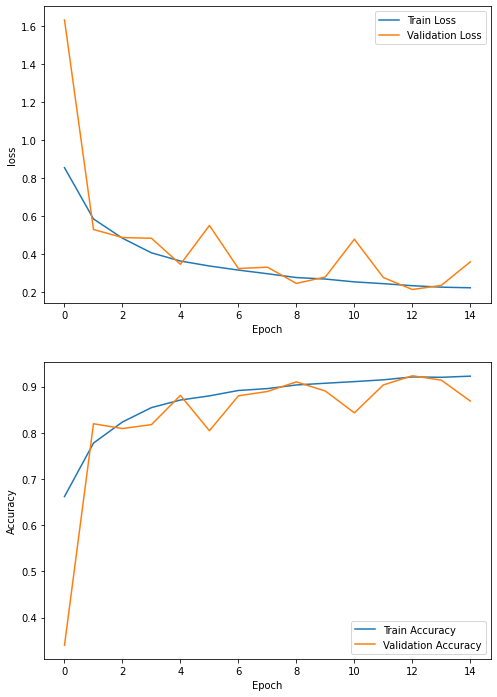

In [25]:
plot_history(hist)

In [22]:
final_model.evaluate(test_gen)

23/23 [==============================] - 16s 635ms/step - loss: 0.3307 - Accuracy: 0.8866


[0.3307172656059265, 0.8865784406661987]